In [ ]:
#Neural network classification with pytorch
#We start by making some data
import sklearn
from sklearn.datasets import make_circles

In [ ]:
#Make a 1000 samples
n_samples = 1000
#Create circles
X, y = make_circles(n_samples, noise=0.03, random_state = 42)

In [ ]:
#1000 samples of x and 1000 labels for each
len(X), len(y)

(1000, 1000)

In [ ]:
#We make a pandas dataframe of the circles data
import pandas as pd
circles = pd.DataFrame({"X1": X[:,0],
                        "X2": X[:,1],
                        "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


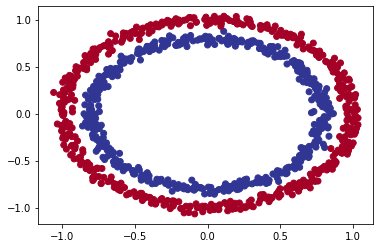

In [ ]:
#The classification problem here is if the data is going to be a blue circle or a red circle
#Now we visualize the data 
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu);

In [ ]:
#Check input and output shapes
X.shape, y.shape

((1000, 2), (1000,))

In [ ]:
#We have to make it into tensors for pytorch
#X has 1000 samples with 2 features
#After tensor conversion we split into train and test
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]), tensor([1., 1., 1., 1., 0.]))

In [ ]:
#Splitting randomly
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [ ]:
len(X_train), len(X_test)

(800, 200)

In [ ]:
#Building a model
#Setup device to run on gpu
#Construct a model (by subclassing nn.Module)
#Define a loss function and optimizer
#Create a train and test loop
from torchsummary import summary
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
X_train.shape, y_train.shape

(torch.Size([800, 2]), torch.Size([800]))

In [ ]:
class CircleModelV0(nn.Module):
  def __init__(self):
    super(CircleModelV0, self).__init__()
    self.two_linear_layers = nn.Sequential(
        nn.Linear(in_features=2, out_features=5),
        nn.Linear(in_features=5, out_features=1),
    )

  def forward(self, x):
    return self.two_linear_layers(x)

In [ ]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super(CircleModelV1, self).__init__()
    self.two_linear_layers = nn.Sequential(
        nn.Linear(in_features=2, out_features=10),
        nn.Linear(in_features=10, out_features=10),
        nn.Linear(in_features=10, out_features=1),
    )

  def forward(self, x):
    return self.two_linear_layers(x)

In [ ]:
#Make an instance of our model class
model_0 = CircleModelV0().to(device=device)
model_0

CircleModelV0(
  (two_linear_layers): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=1, bias=True)
  )
)

In [ ]:
#Make predictions using the untrained model
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape:; {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"First 10 predictions: {torch.round(untrained_preds[:10])}")
print(f"First 10 labels: {y_test[:10]}")

Length of predictions: 200, Shape:; torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])
First 10 predictions: tensor([[-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.]], device='cuda:0')
First 10 labels: tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [ ]:
#Setup loss function and optimizer
#For classification problem we use binary cross entropy or categorical cross entropy
#for optimizers we use either SGD and adam
loss_fn = nn.BCEWithLogitsLoss()#Has sigmoid activation built it
optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr=0.1)

In [ ]:
#Calculate accuracy at the same time
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc=(correct/len(y_pred))*100
  return acc

In [ ]:
#Now our model outputs are going to be raw logits
#We can convert these logits into prediction probabilities by passing them through an activation function here sigmoid 
#We then convert those to prediction labels by either rounding them or taking the argmax()
#For example
with torch.inference_mode():
  y_logits = model_0(X_test.to(device=device))[:5]
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4683],
        [0.4758],
        [0.4524],
        [0.4728],
        [0.4584]], device='cuda:0')

In [ ]:
#For our prediction probability values we need to perform a range style rounding on them
#>=0.5 -> y=1 (class 1) else 0
torch.round(y_pred_probs)

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')

In [ ]:
torch.manual_seed(42)#To ensure reproducability if possible
epochs = 2000

#Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

#Building training and evaluation loop
for epoch in range(epochs):
  #Training
  model_0.train()

  #Forward pass
  y_logits = model_0(X_train).squeeze()#Removes extra one dimension
  y_pred = torch.round(torch.sigmoid(y_logits))#Turns logits into pred probs into pred labels

  #Calculate loss and accuracy
  loss = loss_fn(y_logits, y_train)#Since our loss function is BCEwith logits loss it takes logits
  accuracy = accuracy_fn(y_true=y_train,y_pred=y_pred)

  #Optimizer zero grad
  optimizer.zero_grad()

  #Backward prop
  loss.backward()

  #Optimizer step
  optimizer.step()

  ##Testing 
  model_0.eval()
  with torch.inference_mode():
    #Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    #Calculate the test loss /accuracy
    test_loss = loss_fn(test_logits, y_test)
    test_accuracy = accuracy_fn(y_true=y_test, y_pred=test_pred)

  #printing
  if epoch%10 == 0:
    print(f"Epoch: {epoch}, Loss:{loss:.5f}, Acc: {accuracy:.2f}, test loss:{test_loss:.5f}, test accuracy:{test_accuracy:.2f}")

Epoch: 0, Loss:0.69569, Acc: 50.00, test loss:0.69721, test accuracy:50.00
Epoch: 10, Loss:0.69403, Acc: 50.00, test loss:0.69615, test accuracy:50.00
Epoch: 20, Loss:0.69343, Acc: 46.00, test loss:0.69585, test accuracy:48.50
Epoch: 30, Loss:0.69321, Acc: 49.00, test loss:0.69577, test accuracy:47.50
Epoch: 40, Loss:0.69312, Acc: 49.50, test loss:0.69573, test accuracy:46.50
Epoch: 50, Loss:0.69308, Acc: 50.38, test loss:0.69569, test accuracy:46.50
Epoch: 60, Loss:0.69306, Acc: 50.50, test loss:0.69564, test accuracy:46.50
Epoch: 70, Loss:0.69305, Acc: 50.50, test loss:0.69559, test accuracy:46.50
Epoch: 80, Loss:0.69304, Acc: 50.75, test loss:0.69553, test accuracy:46.50
Epoch: 90, Loss:0.69303, Acc: 50.38, test loss:0.69547, test accuracy:46.50
Epoch: 100, Loss:0.69302, Acc: 50.50, test loss:0.69542, test accuracy:46.50
Epoch: 110, Loss:0.69302, Acc: 50.62, test loss:0.69537, test accuracy:46.00
Epoch: 120, Loss:0.69301, Acc: 50.62, test loss:0.69532, test accuracy:45.50
Epoch: 130

In [ ]:
#Make predictions and evaluate the model
#to inspect it lets make some predictions and make them visual
import requests 
from pathlib import Path
#Download helper functions 
if Path("helper_functions.py").is_file():
  print("helper functions already exists")
else:
  print("Downloading")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py","wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper functions already exists


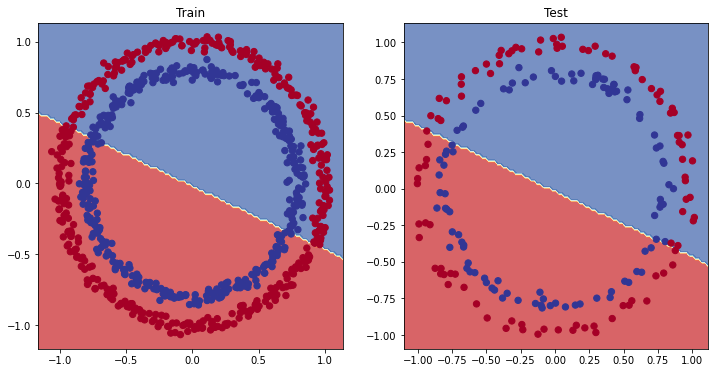

In [ ]:
#Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0,X_test,y_test)

In [ ]:
#Improving a model
#Add more layers to give the model more chances to learn about patterns in the data
#Add more units 
#Fit for longer
#Changing the activation functions 
#change the learning rate 
#Changing the loss functions

In [ ]:
#Create some data and a smaller model to see if it can fit a straight line 
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

#Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight*X_regression + bias

#Check the data
print(len(X_regression))
print(len(y_regression))

100
100


In [ ]:
#Create train and test splits
train_split = int(0.8*len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

#Check the lengths of each
len(X_train_regression), len(X_test_regression)

(80, 20)

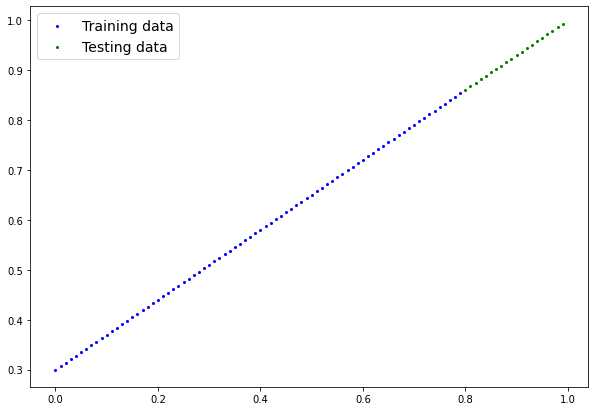

In [ ]:
plot_predictions(train_data = X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression)

In [ ]:
model_1 = CircleModelV1()
model_1

CircleModelV1(
  (two_linear_layers): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [ ]:
class CircleModelV2(nn.Module):
  def __init__(self):
    super(CircleModelV2, self).__init__()
    self.two_linear_layers = nn.Sequential(
        nn.Linear(in_features=1, out_features=10),
        nn.Linear(in_features=10, out_features=10),
        nn.Linear(in_features=10, out_features=1),
    ).to(device)

  def forward(self, x):
    return self.two_linear_layers(x)

model_2 = CircleModelV2().to(device)
model_2

CircleModelV2(
  (two_linear_layers): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [ ]:
#Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.01)

In [ ]:
#Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#Set the number of epochs
epochs = 1000

#Put our data on the target device 
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

In [ ]:
#Training
for epoch in range(epochs):
  y_pred = model_2(X_train_regression)
  loss = loss_fn(y_pred,y_train_regression)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_2.eval()
  with torch.inference_mode():
    test_pred = model_2(X_test_regression)
    test_loss = loss_fn(test_pred, y_test_regression)

#printing
  if epoch%100 == 0:
    print(f"Epoch: {epoch}, Loss:{loss:.5f}, test loss:{test_loss:.5f}")

Epoch: 0, Loss:0.57896, test loss:0.82273
Epoch: 100, Loss:0.03496, test loss:0.00156
Epoch: 200, Loss:0.03268, test loss:0.00330
Epoch: 300, Loss:0.02942, test loss:0.00446
Epoch: 400, Loss:0.02731, test loss:0.00570
Epoch: 500, Loss:0.02671, test loss:0.00534
Epoch: 600, Loss:0.02627, test loss:0.00511
Epoch: 700, Loss:0.02594, test loss:0.00496
Epoch: 800, Loss:0.02482, test loss:0.00394
Epoch: 900, Loss:0.02333, test loss:0.00462


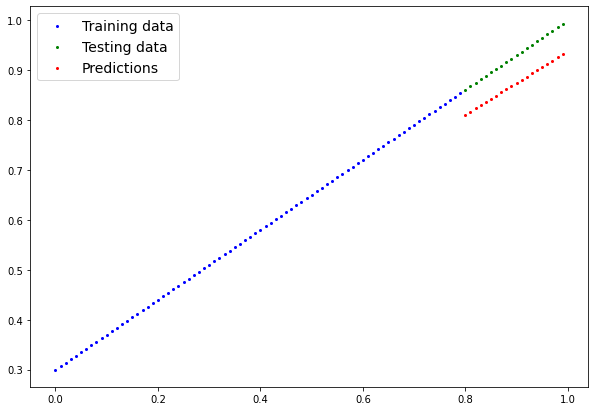

In [ ]:
#Turn on evaluation mode
model_2.eval()

#Make predictions 
with torch.inference_mode():
  y_preds = model_2(X_test_regression)

#Plot data and predictions 
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels = y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu())

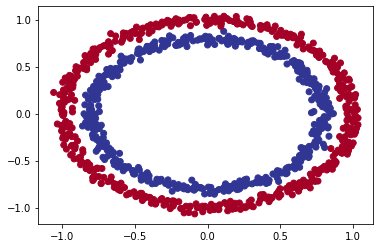

In [ ]:
##The missing piece of our model is non-linearity
#Recreating non linear data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000
X,y = make_circles(n_samples,
                   noise=0.03,
                   random_state=42)
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu)

In [ ]:
#Convert the data into tensors and train and test splits
from sklearn.model_selection import train_test_split
import torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

#Split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [ ]:
#Build a model with non-linear functionctions
class CircleModelV3(nn.Module):
  def __init__(self):
    super(CircleModelV3, self).__init__()
    self.three_linear_layers = nn.Sequential(
        nn.Linear(in_features=2, out_features=10),
        nn.ReLU(),
        nn.Linear(in_features=10, out_features=10),
        nn.ReLU(),
        nn.Linear(in_features=10, out_features=1)
    )

  def forward(self, x):
    return self.three_linear_layers(x)

In [ ]:
model_3=CircleModelV3().to(device)
model_3

CircleModelV3(
  (three_linear_layers): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [ ]:
#Optimizer and loss function
loss_fn = nn.BCEWithLogitsLoss()#Has sigmoid activation built it
optimizer = torch.optim.SGD(params = model_3.parameters(),
                            lr=0.1)

In [ ]:
#Random seeds 
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#Put all the data on target device 
X_train,y_train = X_train.to(device), y_train.to(device)
X_test,y_test = X_test.to(device), y_test.to(device)

#Loop through data
epochs = 2000

for epoch in range(epochs):
  model_3.train()

  #Forward pass
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  #loss
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  #Optimizer zero grad
  optimizer.zero_grad()

  #Backward Propagation
  loss.backward()

  #Optimizer step
  optimizer.step()

  #Testing
  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)
    
  if epoch%100 == 0:
    print(f"Epoch: {epoch}, Loss:{loss:.5f}, Acc: {acc:.2f}, test loss:{test_loss:.5f}, test accuracy:{test_acc:.2f}")

Epoch: 0, Loss:0.69295, Acc: 50.00, test loss:0.69319, test accuracy:50.00
Epoch: 100, Loss:0.69115, Acc: 52.88, test loss:0.69102, test accuracy:52.50
Epoch: 200, Loss:0.68977, Acc: 53.37, test loss:0.68940, test accuracy:55.00
Epoch: 300, Loss:0.68795, Acc: 53.00, test loss:0.68723, test accuracy:56.00
Epoch: 400, Loss:0.68517, Acc: 52.75, test loss:0.68411, test accuracy:56.50
Epoch: 500, Loss:0.68102, Acc: 52.75, test loss:0.67941, test accuracy:56.50
Epoch: 600, Loss:0.67515, Acc: 54.50, test loss:0.67285, test accuracy:56.00
Epoch: 700, Loss:0.66659, Acc: 58.38, test loss:0.66322, test accuracy:59.00
Epoch: 800, Loss:0.65160, Acc: 64.00, test loss:0.64757, test accuracy:67.50
Epoch: 900, Loss:0.62362, Acc: 74.00, test loss:0.62145, test accuracy:79.00
Epoch: 1000, Loss:0.56818, Acc: 87.75, test loss:0.57378, test accuracy:86.50
Epoch: 1100, Loss:0.48153, Acc: 93.50, test loss:0.49935, test accuracy:90.50
Epoch: 1200, Loss:0.37056, Acc: 97.75, test loss:0.40595, test accuracy:92.0

In [ ]:
#Evaluating a model trained with non linear activation functions
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

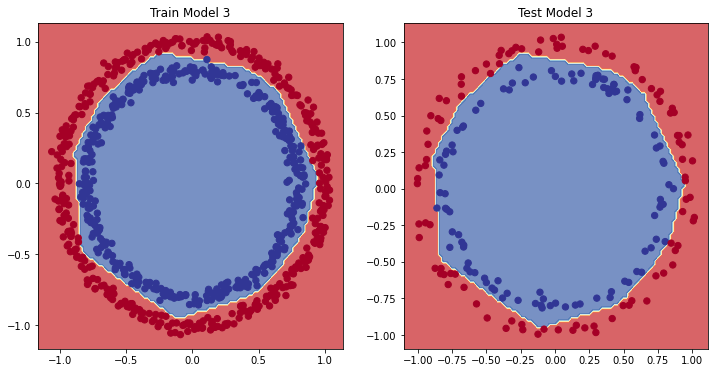

In [ ]:
#PLot decision boundaries
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train Model 3")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test Model 3")
plot_decision_boundary(model_3,X_test,y_test)

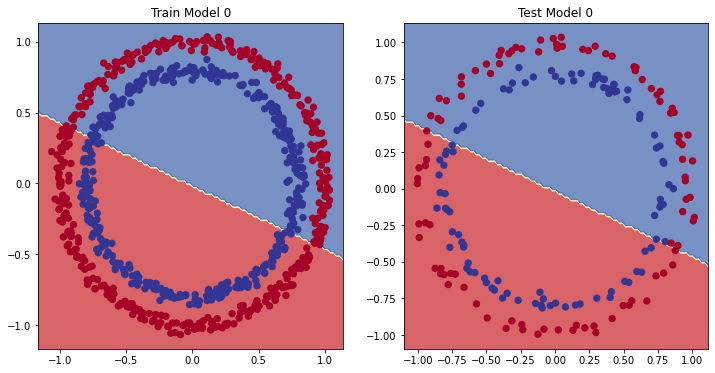

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train Model 0")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test Model 0")
plot_decision_boundary(model_0,X_test,y_test)

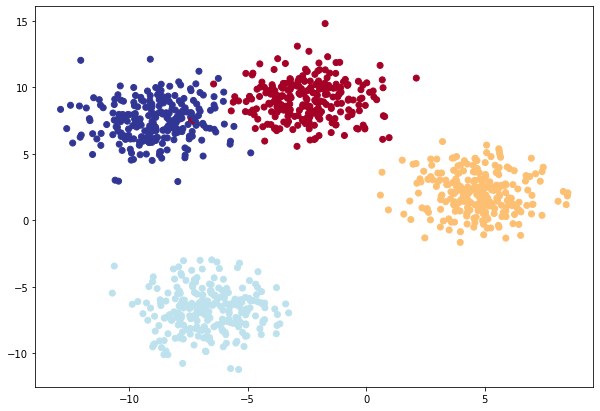

In [ ]:
#Multiclass classification
#Create a toy multi class dataset
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

#Set hyperparameters
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob,y_blob = make_blobs(n_samples = 1000,
                           n_features = NUM_FEATURES,
                           centers = NUM_CLASSES,
                           cluster_std = 1.5,
                           random_state = RANDOM_SEED)

#Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

#Split
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,y_blob,test_size=0.2,random_state=RANDOM_SEED)

#Plot the data
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0],X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [ ]:
#Build a model
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

#Create an instance of blob model
model_4 = BlobModel(input_features=2, output_features=4,
                    hidden_units=8).to(device=device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [ ]:
 #Create a loss and optimizer and training loop
 loss_fn = nn.CrossEntropyLoss()
 optimizer = torch.optim.SGD(model_4.parameters(), lr=0.1)

In [ ]:
#Getting prediction probabilities for a multi class model
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test.to(device))
y_logits[:10]

tensor([[ 0.7111, -0.5330,  0.3307, -0.2327],
        [-0.3420, -1.7850, -0.3224, -1.1384],
        [ 0.1878, -0.8563,  0.3375, -0.9026],
        [ 0.4513, -0.4277,  0.2498, -0.1940],
        [ 0.8922, -0.9492,  0.3245, -0.5287],
        [-0.4885, -2.0119, -0.4004, -1.3252],
        [ 0.2586, -0.8477,  0.2739, -0.8695],
        [ 0.6816, -1.1144,  0.2053, -0.6434],
        [ 0.3433, -1.0156,  0.4706, -1.1226],
        [ 0.7687, -1.0243,  0.2629, -0.5887]], device='cuda:0')

In [ ]:
y_blob_test[:10]
#We need to convert our models outputs to prediction probabilities to prediction labels
#For binary we used sigmoid and for multi class classification we use softmax

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')

Logits -> Pred Probabilities using softmax -> Pred Labels using argmax

In [ ]:
#Conversion
y_pred_probs = torch.softmax(y_logits, dim=1)
#print(y_pred_probs[:10])
#If we use torch.sum or torch.max we get different results
#in the models words we have..this is how much i think this is this class
#to get the index of the max value we use arg max
#conversion of pred probs to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([0, 2, 2, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2,
        2, 2, 2, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0,
        2, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2,
        0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2,
        2, 2, 0, 0, 2, 0, 0, 0, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,
        2, 2, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 0, 2, 2, 0, 2, 2, 0,
        2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 2, 2, 0, 0, 2, 2, 0, 0,
        0, 2, 2, 0, 2, 0, 2, 0], device='cuda:0')

In [ ]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1], device='cuda:0')

In [ ]:
#Training the network
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

#Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

#Loop through data
for epoch in range(epochs):
  model_4.train()
  #Forward pass
  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true = y_blob_train,
                    y_pred = y_pred)
  
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  #Check on testing
  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test,
                           y_pred=test_preds)
    
  #Print
  if epoch%10==0:
    print(f"Epoch: {epoch}, Loss:{loss:.4f}, Acc:{acc:.2f}, test loss:{test_loss:.4f}, test_acc:{test_acc:.2f}")

Epoch: 0, Loss:1.0902, Acc:70.50, test loss:0.9338, test_acc:77.00
Epoch: 10, Loss:0.6198, Acc:72.88, test loss:0.5200, test_acc:79.50
Epoch: 20, Loss:0.4797, Acc:73.12, test loss:0.3978, test_acc:79.00
Epoch: 30, Loss:0.3941, Acc:81.88, test loss:0.3248, test_acc:85.50
Epoch: 40, Loss:0.3256, Acc:90.12, test loss:0.2673, test_acc:90.00
Epoch: 50, Loss:0.2435, Acc:95.88, test loss:0.1964, test_acc:99.00
Epoch: 60, Loss:0.1456, Acc:98.50, test loss:0.1161, test_acc:99.00
Epoch: 70, Loss:0.0888, Acc:98.88, test loss:0.0712, test_acc:99.00
Epoch: 80, Loss:0.0647, Acc:98.88, test loss:0.0519, test_acc:99.00
Epoch: 90, Loss:0.0531, Acc:98.88, test loss:0.0425, test_acc:99.00


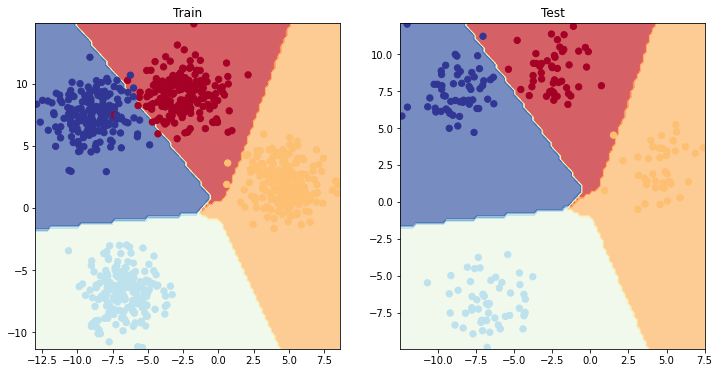

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4,X_blob_test,y_blob_test)